# MÓDULO 4: LA CIENCIA DE DATOS Y LOS MODELOS DE ANALÍTICA PREDICTIVA EN LA INDUSTRIA 4.0

# 5- Aprendizaje semi-supervisado

## Label Propagation en dígitos y active learning

En este notebook de ejemplo se muestra la técnica active learning y label propagation para el aprendizaje de dígitos escritos a mano.

La idea consiste en entrenar el modelo basado en label propagation siguiendo el siguiente proceso: 

* Entrenamos con únicamente 10 puntos etiquetados
* Seleccionamos los 5 puntos con mayor incertidumbre al etiquetar
* Entrenamos con 15 puntos etiquetados (los 10 originales + 5 nuevos)
* Repetimos este proceso 4 veces para tener un modelo entrenado con 30 puntos etiquetados

De esta manera vamos visualizando los dígitos para los cuales el modelo tuvo más problemas a la hora de propagar las etiquetas, lo cual puede ser muy útil para etiquetar con active learning de manera iterativa. 

Referencias:
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.semi_supervised
- https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Cargamos los datos y mostramos un ejemplo de dígito

(1797, 64)
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


<Figure size 432x288 with 0 Axes>

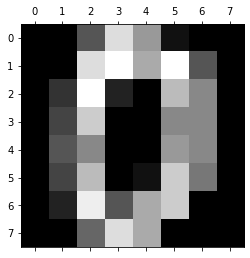

In [2]:
digits = datasets.load_digits(n_class=10)
print(digits.data.shape)
print(digits.data)
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

Ejecutamos el proceso un total de 5 iteraciones con un subset de 330 dígitos

In [3]:
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)
X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 10
max_iterations = 5

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]
f = plt.figure()

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1

    lp_model = LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels,
                          labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points,
             n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([], dtype=int)

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        f.text(.05, (1 - (i + 1) * .183),
               "model %d\n\nfit with\n%d labels" %
               ((i + 1), i * 5 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
            sub.set_title("predict: %i\ntrue: %i" % (
                lp_model.transduction_[image_index], y[image_index]), size=10)
            sub.axis('off')

        # labeling 5 points, remote from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle("Active learning with Label Propagation.\nRows show 5 most "
           "uncertain labels to learn with the next model.", y=1.15)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2,
                    hspace=0.85)
plt.show()

NameError: name 'LabelSpreading' is not defined

<Figure size 432x288 with 0 Axes>